In [8]:

import matplotlib.pyplot as plt
from scipy.signal import convolve, deconvolve
import scipy.stats as stats
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt
import scipy.signal as signal
import matplotlib.gridspec as gridspec
import importlib
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import iminuit
import iminuit.cost
import sympy as syp
import importlib

import TpyC as tc


##### <u>E1/E2/Mixing Angular Distribution Formula: cos($\theta$)</u>

$$W\left(\cos\left(\theta\right)|\sigma_{\mathrm{E1}},\sigma_{\mathrm{E2}}, \phi_{12}\right)=\sigma_{\mathrm{E1}} \cdot W_{\mathrm{E1}}\left(\cos\left(\theta\right)\right)+\sigma_{\mathrm{E2}}\cdot W_{\mathrm{E2}}\left(\cos\left(\theta\right)\right)+ \sqrt{\sigma_{\mathrm{E1}}\sigma_{\mathrm{E2}}}\cdot\cos{\left(\phi_{12}\right)}\cdot W_{12}\left(\cos\left(\theta\right)\right) $$  


TODO: show proof for cos($\theta$) -> $\theta$, by multiplication of sin($\theta$)


#### <u>Normalisation of E1/E2/Mixing Angular Distribution Formula: $\theta$</u>


In [11]:
theta, phi12, sigma_E1, sigma_E2 = syp.symbols('theta phi12 sigma_E1 sigma_E2')

P0 = 1
P1 = syp.legendre(1, syp.cos(theta))
P2 = syp.legendre(2, syp.cos(theta))
P3 = syp.legendre(3, syp.cos(theta))
P4 = syp.legendre(4, syp.cos(theta))

W_E1 = P0 - P2
W_E2 = P0 + (5/7) * P2 - (12/7) * P4
W_12 = (6 / syp.sqrt(5)) * (P1 - P3)

W_theta = sigma_E1 * W_E1 + sigma_E2 * W_E2 + syp.sqrt(sigma_E1 * sigma_E2) * syp.cos(phi12) * W_12
W_theta=W_theta*syp.sin(theta)

norm = syp.integrate(W_theta, (theta, 0, syp.pi))
print(norm)

W_theta=W_theta/norm
simplified_W_theta = syp.simplify(W_theta)

print(simplified_W_theta)

2.0*sigma_E1 + 2.0*sigma_E2
(0.75*sigma_E1 - 3.75*sigma_E2*sin(theta)**2 + 3.75*sigma_E2 + 1.5*sqrt(5)*sqrt(sigma_E1*sigma_E2)*cos(phi12)*cos(theta))*sin(theta)**3/(sigma_E1 + sigma_E2)




PDF:

$$W\left(\theta|\sigma_{\mathrm{E1}},\sigma_{\mathrm{E2}}, \phi_{12}\right)= \frac{({0.75 \cdot \mathrm{\sigma_{\mathrm{E1}} - 3.75 \cdot \sigma_{\mathrm{E2}} \cdot \sin^2(\theta) + 3.75 \cdot \sigma_{\mathrm{E2}} + 1.5 \cdot \sqrt{5} \cdot \sqrt{\sigma_{\mathrm{E1}}  \cdot \sigma_{\mathrm{E2}}}} \cdot \cos(\phi) \cdot \cos(\theta)) \cdot \sin^3(\theta)}}{{\sigma_{\mathrm{E1}} + \sigma_{\mathrm{E2}}}}$$

or

$$W(\theta|\sigma_{\mathrm{E1}},\sigma_{\mathrm{E2}}, \phi_{12}) = \frac{\sin^3(\theta)}{4} \cdot \frac{{\left(3\mathrm{\sigma_{\mathrm{E1}}} +15\mathrm{\sigma_{\mathrm{E2}}}( 1 -\sin^2(\theta) ) + 6 \sqrt{5\mathrm{\sigma_{\mathrm{E1}}}  \cdot \mathrm{\sigma_{\mathrm{E2}}}} \cdot \cos(\phi) \cdot \cos(\theta)\right) }}{{\mathrm{\sigma_{\mathrm{E1}}} + \mathrm{\sigma_{\mathrm{E2}}}}}$$



PDF as ratio:


$$W\left(\theta|\frac{\sigma_{\mathrm{E2}}}{\sigma_{\mathrm{E1}}}, \phi_{12}\right)=\frac{\sin^3(\theta)}{4} \cdot \frac{{\left(3 + 15 \frac{\sigma_{\mathrm{E2}}}{\sigma_{\mathrm{E1}}} ( 1 -\sin^2(\theta))+ 6\sqrt{5\frac{\sigma_{\mathrm{E2}}}{\sigma_{\mathrm{E1}}}} \cdot \cos(\phi_{12}) \cdot \cos(\theta)\right) }}{{1 + \frac{\sigma_{\mathrm{E2}}}{\sigma_{\mathrm{E1}}}}}$$


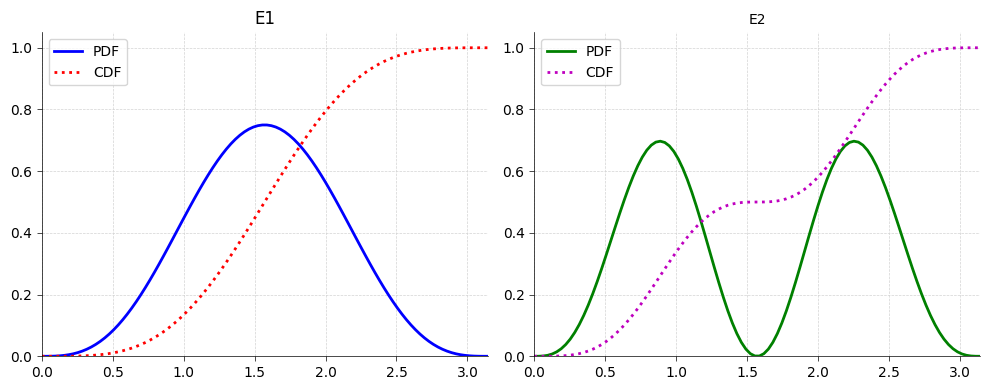

In [21]:
import TpyC as tc
importlib.reload(tc);


fig, axs = plt.subplots(1, 2, figsize=(10, 4))
plt.subplots_adjust(wspace=.0)
axs = axs.reshape(-1)
x = np.linspace(0, np.pi, 100)
n = 100000

# Plot the first distribution
importlib.reload(tc);
dist=tc.angular12_theta(1,0,phi=np.pi/2)
ax = axs[0]
ax.plot(x, dist.pdf(x), label='PDF', color='b', linewidth=2)
ax.plot(x, dist.cdf(x), label='CDF', color='r', linewidth=2, linestyle='dotted')
ax.set_title('E1', fontsize=12)
ax.legend(loc='upper left', fontsize=10)
ax.set_xlim(0, np.pi)  # Set xlim from 0 to pi
ax.set_ylim(0)
tc.stylise_plot(ax)

# Plot the second distribution
dist=tc.angular12_theta(0,1,phi=np.pi/2)
ax = axs[1]
ax.plot(x, dist.pdf(x), label='PDF', color='g', linewidth=2)
ax.plot(x, dist.cdf(x), label='CDF', color='m', linewidth=2, linestyle='dotted')
ax.set_title('E2', fontsize=10)
ax.legend(loc='upper left', fontsize=10)
ax.set_xlim(0, np.pi)  # Set xlim from 0 to pi
ax.set_ylim(0)
tc.stylise_plot(ax)
plt.tight_layout()
plt.show()

### <u>Convolution test: 1</u>

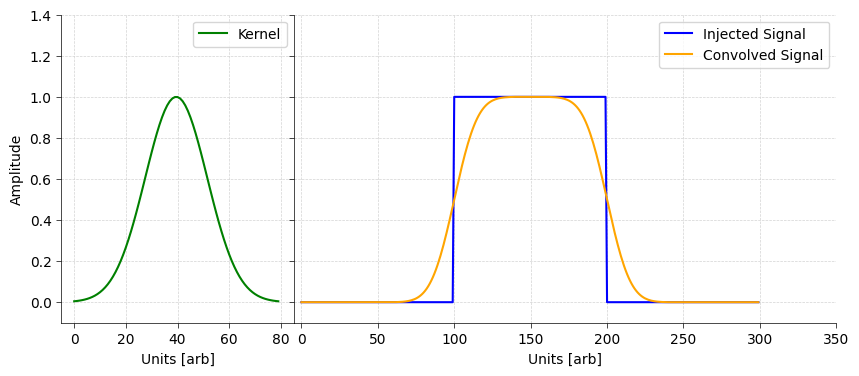

In [7]:
import TpyC as tc
importlib.reload(tc);

original_signal = np.repeat([0., 1., 0.], 100)
kernel = signal.windows.gaussian(80,12)
convolved_signal = np.convolve(original_signal, kernel, mode='same')
recovered_signal,  _ = scipy.signal.deconvolve( convolved_signal, kernel )

#########################################################

grid_spec = gridspec.GridSpec(1, 2, width_ratios=[3, 7])
plt.figure(figsize=(10, 4))  # Adjust the width and height of the figure as needed
plt.subplots_adjust(wspace=.0) # Adjust the horizontal spacing between subplots
ax1 = plt.subplot(grid_spec[0])
ax2 = plt.subplot(grid_spec[1])

ax1.plot(kernel, label='Kernel', marker='', color='green')
ax1.set_xlabel('Units [arb]')
ax1.set_ylabel('Amplitude')
ax1.legend(  fontsize='medium', title_fontsize='medium', loc='upper right')
ax1.set_ylim(-0.1,1.4)
ax1.set_xlim(-5,85)
tc.stylise_plot(ax1)

ax2.plot(original_signal, label='Injected Signal', marker='', color='blue')
ax2.set_xlabel('Units [arb]')
ax2.plot(convolved_signal/np.sum(kernel), label='Convolved Signal', marker='', color='orange')
ax2.legend(  fontsize='medium', title_fontsize='medium', loc='upper right')
ax2.set_ylim(-0.1,1.4)
ax2.set_xlim(-5,350)
tc.stylise_plot(ax2)

ax2.set_yticklabels([])  # Turn off y tick labels
ax2.legend(  fontsize='medium', title_fontsize='medium', loc='upper right')
plt.show()

#### <u> PDF Generator with resolution </u>

[ 0. nan nan ... nan nan  1.]


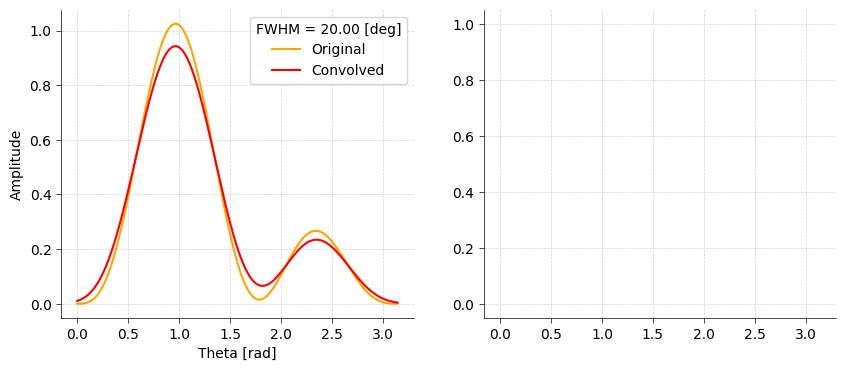

In [184]:
import TpyC as tc
importlib.reload(tc);

degConv = 20

x = np.linspace(0, np.pi, 40000) # this number of points is fine for up to around 80/100 degree convolution. 

dist= tc.angular12_theta(0.1,0.4,phi=np.deg2rad(19)) ## angular12_theta(E1,E2,phi12)
y_pdf = dist.pdf(x)
y_cdf = dist.cdf(x)

dist2 = tc.angular12_theta_conv(0.1,0.4,phi=np.deg2rad(19)) ## angular12_theta(E1,E2,phi12)
y_pdf_conv = dist2.pdf(x,degConv)
y_cdf_conv = dist2.cdf(x,degConv)

fig, axs = plt.subplots(1,2, figsize=(10, 4))
ax=axs[0]
ax.plot(x,y_pdf,color='orange', label='Original')
ax.plot(x,y_pdf_conv,color='red', label='Convolved')
tc.stylise_plot(ax)
ax.legend(title=f'FWHM = {degConv:.2f} [deg]', fontsize='medium', title_fontsize='medium', loc='upper right');
ax.set_xlabel('Theta [rad]');
ax.set_ylabel('Amplitude');

ax=axs[1]
#ax.plot(x,y_cdf,color='orange', label='Original')
ax.plot(x,y_cdf_conv,color='red', label='Convolved')
tc.stylise_plot(ax)
print(y_cdf_conv)


CDF with res

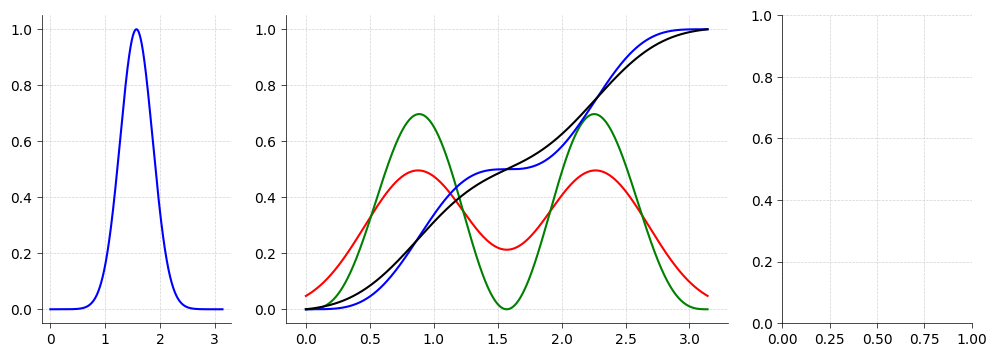

In [166]:
# Probability density function is first derivative of cumulative distribution function

from scipy.integrate import simps
import numpy as np
import scipy.signal as signal
import math
from scipy.integrate import quad
from scipy.stats import norm



def gaussian_cdf_from_kernel(kernel):
    return np.cumsum(kernel) / np.sum(kernel)


def conv(x,degrees,y,cdf):

    numberOfPoints = len(x)
    startXval = x[0]
    endXval =  x[len(x)-1]
    rangeOfVals  = endXval - startXval
    degreesToConv = degrees
    radiansToConv = np.deg2rad(degreesToConv)
    XPerRad =  numberOfPoints/rangeOfVals 
    XtoConv = XPerRad*radiansToConv
    Res_to_SD = lambda fwhm: fwhm / (2 * np.sqrt(2 * np.log(2)))
    SD_X = Res_to_SD(XtoConv)

    kernel = signal.windows.gaussian(numberOfPoints,SD_X)
    
   # kernal_CDF = gaussian_cdf_from_kernel(kernel)


    ## convolve PDF ##
    convolved_signal = np.convolve(y, kernel, mode='same')
    convolved_signal=convolved_signal/sum(kernel)
    ## convolve CDF ##
    convolved_pdf_cdf = np.cumsum(convolved_signal)
    convolved_pdf_cdf /= convolved_pdf_cdf[-1]  # Normalize to get values between 0 and 1


   # convolved_signa2l = np.convolve(ycdf, kernal_CDF, mode='same')
   # convolved_signa2l=convolved_signa2l/sum(kernal_CDF)


    #############################################
    grid_spec = gridspec.GridSpec(1, 3, width_ratios=[3, 7,3])
    plt.figure(figsize=(12, 4))  # Adjust the width and height of the figure as needed
    ax1 = plt.subplot(grid_spec[0])
    ax2 = plt.subplot(grid_spec[1])
    ax3 = plt.subplot(grid_spec[2])
   
    ax1.plot(x,kernel, color='blue')
   # ax3.plot(x,kernal_CDF, color='red')
             
    ax2.plot(x,convolved_signal, label='Convolved -PDF', marker='', color='red')
    ax2.plot(x,y, label='Convolved - CDF', marker='', color='green')
    ax2.plot(x,cdf, label='Original -PDF', marker='', color='blue')
   
    ax2.plot(x,convolved_pdf_cdf,label='Original -CDF' ,marker='', color='black')

    tc.stylise_plot(ax1)
    tc.stylise_plot(ax2)
    tc.stylise_plot(ax3)


x = np.linspace(0, np.pi, 4000)
dist=tc.angular12_theta(0,1,phi=np.deg2rad(19))
conv(x,40, dist.pdf(x),dist.cdf(x))


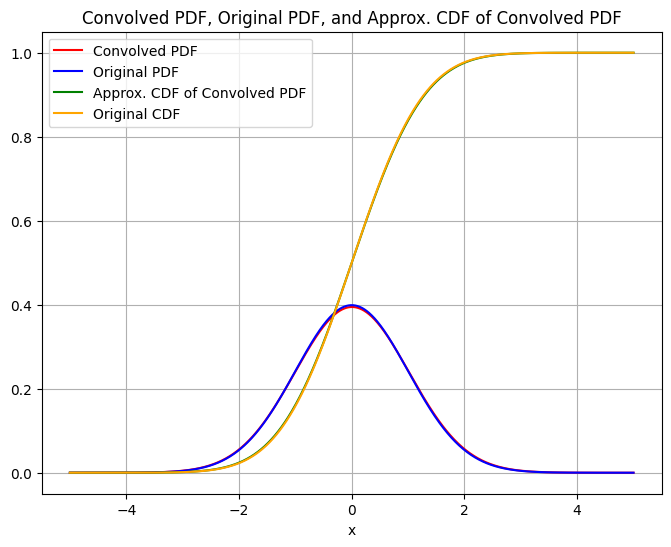

In [137]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.stats import norm

def gaussian_cdf_from_kernel(kernel):
    return np.cumsum(kernel) / np.sum(kernel)

def conv(x, degrees, y, ycdf):
    numberOfPoints = len(x)
    startXval = x[0]
    endXval = x[len(x) - 1]
    rangeOfVals = endXval - startXval
    degreesToConv = degrees
    radiansToConv = np.deg2rad(degreesToConv)
    XPerRad = numberOfPoints / rangeOfVals
    XtoConv = XPerRad * radiansToConv
    Res_to_SD = lambda fwhm: fwhm / (2 * np.sqrt(2 * np.log(2)))
    SD_X = Res_to_SD(XtoConv)

    kernel = signal.windows.gaussian(numberOfPoints, SD_X)
    kernal_CDF = gaussian_cdf_from_kernel(kernel)

    ## convolve PDF ##
    convolved_signal = np.convolve(y, kernel, mode='same')
    convolved_signal = convolved_signal / sum(kernel)

    # Numerically approximate the CDF of the convolved PDF
    convolved_pdf_cdf = np.cumsum(convolved_signal)
    convolved_pdf_cdf /= convolved_pdf_cdf[-1]  # Normalize to get values between 0 and 1

    #############################################
    plt.figure(figsize=(8, 6))
    plt.plot(x, convolved_signal, label='Convolved PDF', color='red')
    plt.plot(x, y, label='Original PDF', color='blue')
    plt.plot(x, convolved_pdf_cdf, label='Approx. CDF of Convolved PDF', color='green')
    plt.plot(x, ycdf, label='Original CDF', color='orange')
    plt.xlabel('x')
    plt.title('Convolved PDF, Original PDF, and Approx. CDF of Convolved PDF')
    plt.legend()
    plt.grid(True)
    plt.show()

# Create example data using standard Gaussian distribution
x = np.linspace(-5, 5, 1000)
y = norm.pdf(x, loc=0, scale=1)  # PDF of standard Gaussian distribution
ycdf = norm.cdf(x, loc=0, scale=1)  # CDF of standard Gaussian distribution

conv(x, 20, y, ycdf)

